# Simulation of Ising Model 

The purpose of the Ising model is to describe ferromagnetism in solid matter. This model is describe as follows:
- The solid is described by a regular lattice.
- Each lattice point is assigned a magnetic dipole that has only two states (-1 or +1).
- All magnetic dipoles are aligned to the same axis.
- The magnetic dipoles only influence their nearest neighbours (cardinal directions)
This description provides an approximation to the regular lattice structure of atoms in solids such as metals, where the magnetization is caused by the orientation of the nuclear magnetic moment.

Simulating the Ising model by explicitly calculating all possible configurations of the lattice is very inefficient and not realistic for large lattices. We therefore want to employ a Monte Carlo simulation to determine equilibrium magnetization and energy of the system for a given temperature.

We begin by importing the required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

The algorithm chosen for this simulation is the metropolis algorithm.
In this implementation specifically, we take advantage of the short range interaction of the magentic force. Instead of iterating over all lattice points sequencially, we will instead iterate over points in a checkerboard pattern. We distiguish between "white" positions which have even sum of coordinates (indexes in this case) and "black" positions, with uneven coordinates. \
All lattice points of the same color do not interact with one onther through magnetic force, as their cardinal neighbours are all of the opposite color. We can therefore iterate over these simultaniously and change their spin at the same time. 
To complete the iteration over all lattice points we repeat the same process for the other color lattice points while using the updated configuration produced by the previous color iteration.

In [57]:
def metropolis_algorithm(N,D,beta,b,random_seed:int, config_n, initial_config_type):
    assert initial_config_type == "hot" or initial_config_type == "cold", f"initial_config_type must be either 'hot' or 'cold'"
    np.random.seed(random_seed)
    
    if initial_config_type == "cold":
        config = np.ones((N,)*D)
    elif initial_config_type == "hot":
        config =  np.random.choice([-1, 1], size=(N,)*D, p=[0.5, 0.5])


    magnetization_array = np.zeros((config_n,))
    energy_array = np.zeros((config_n,))

    def checkerboard_mask(shape):
        return np.indices(shape).sum(axis=0) % 2 == 0
    white_mask = checkerboard_mask((N,)*D)
    black_mask = np.logical_not(white_mask)
    

    # iterate over number of configurations (0.62seconds/1000 iters)
    for config_iter in range(config_n):
        

        #checkerboard array approach

        # random number array
        random_numbers = np.random.rand(N**D)
        random_array = random_numbers.reshape((N,)*D)

        # white
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            neighbours = neighbours + (np.roll(config,1, axis=i)+np.roll(config,-1, axis=i))

        dH_array_white = np.exp(-(2*beta*config*neighbours +2*b*config))
        #only look at white indexes
        dH_array_white[black_mask] = 0
        white_flip_mask = dH_array_white > random_array
        # now flip accordingly based off of white spins
        config[white_flip_mask]*=-1
        # print(config)
        # now repeat for black
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            neighbours = neighbours + (np.roll(config,1, axis=i)+np.roll(config,-1, axis=i))

        dH_array_black = np.exp(-(2*beta*config*neighbours +2*b*config))
        #only look at even indexes
        dH_array_black[white_mask] = 0
        black_flip_mask = dH_array_black > random_array
        
        config[black_flip_mask]*=-1

        
        
        magnetization_array[config_iter] = np.sum(config)

        #calculate config energy
        neighbours = np.zeros((N,)*D)
        for i in range(D):
            #only add right neighbours
            neighbours = neighbours + np.roll(config,1, axis=i)
        energy_config = np.sum(-beta*config*neighbours -b*config)
        energy_array[config_iter] = energy_config

    return magnetization_array, energy_array

We shall now use the metropolis algorithm to simulate the magentization of a 100x100 lattice over 1000 configurations. We can set the following parameters for the simulation:
- $\beta$ =  $\frac{J}{k_BT}$ : Describes the Interaction strength of the atoms relative to the temperature of the system. 
- b = $\frac{\mu B}{k_BT}$ : Describes the strenght of the external magnetic field $B$ and the magnetic moment $\mu$.
- seed: integer number that selects the seed for random number generation.

In [7]:
magnetization_history, energy_history = metropolis_algorithm(100,2,0.43,0.01, 42,1000,"hot")

We can now plot the history of total magnetization and energy of the lattice over the number of configurations simulated. Magnetization is defined as the sum of all the spins in the configuration. The energy is calculated through the formula \
$$
\hat{H} = -B\sum_{\bm{n}}\sum_{k=1}^{D}s(\bm{n})s(\bm{n}+\bm{e}_k) - b\sum_{\bm{n}}  s(\bm{n}),
$$
where  $\bm{n}$ describes the lattice point coordinate and $s(\bm{n})$ is the spin at the given position. 


We observe that after a thermalization phase, the magnetization and energy of the following configurations fluctuate around the true value the system reaches for given parameters.

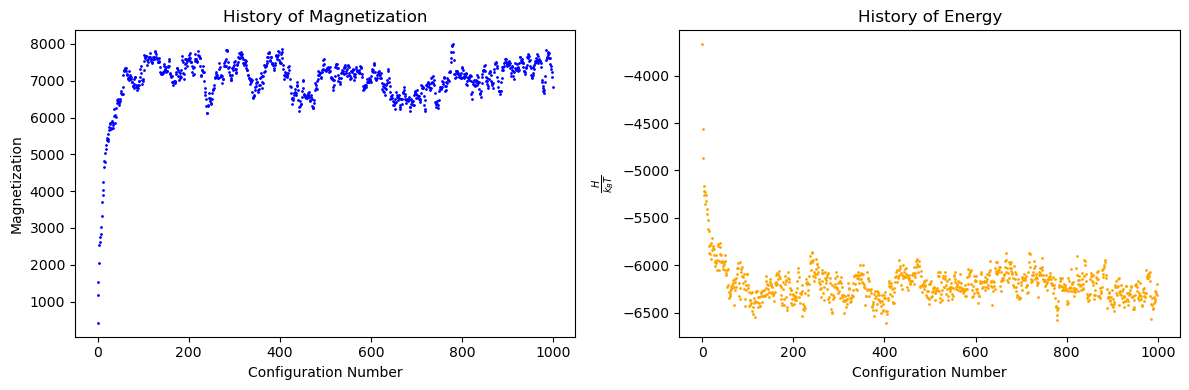

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
axes[0].scatter(range(1000),magnetization_history, color='blue', s = 1)
axes[0].set_xlabel('Configuration Number')
axes[0].set_ylabel('Magnetization')
axes[0].set_title('History of Magnetization')

# Plot Energy
axes[1].scatter(range(1000),energy_history, color='orange', s = 1)
axes[1].set_xlabel('Configuration Number')
axes[1].set_ylabel(r'$\frac{H}{k_B T}$')
axes[1].set_title('History of Energy')

plt.tight_layout()
plt.show()

### Statistical error of the metropolis algorithm

The metropolis algorithm provides a stochastic estimate of the observables $M$ and $H$. We shall now determine the statistical error of the observables through the replica method. Hereby we create replicas of the simulation (with unique random seeds) and compare the thermalized configuration magnetization and energy. We start by repeating the metropolis algorithm 500 times and storing the magnetization and energy values.

In [4]:
replica_count = 500
config_number = 1000

In [10]:

magnetization_replicas = []
energy_replicas = []
for i in range (replica_count):
    print(i, end='\r')
    magnetization_history, energy_history = metropolis_algorithm(100,2,0.43,0.01, i,config_number,"hot")
    magnetization_replicas.append(magnetization_history)
    energy_replicas.append(energy_history)


Save the magnetization and energy to file.

In [11]:
np.save(f'ising_output/magnetization_{replica_count}.npy', magnetization_replicas)
np.save(f'ising_output/energy_{replica_count}.npy', energy_replicas)

Load magnetization and energy from file.

In [5]:
magnetization_replicas = np.load(f'ising_output/magnetization_{replica_count}.npy')
energy_replicas = np.load(f'ising_output/energy_{replica_count}.npy')

We can now plot the two observables over the configuration count for all replicas and manually determine the thermalization time. In this case we set thermalization time to 200 configurations.

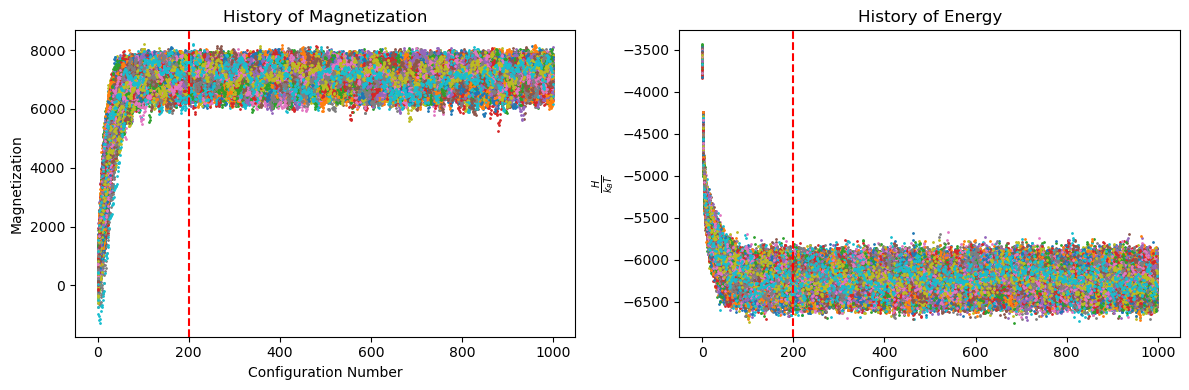

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
for magnetization_history in magnetization_replicas:
    axes[0].scatter(range(config_number),magnetization_history, s = 1)
    axes[0].set_xlabel('Configuration Number')
    axes[0].set_ylabel('Magnetization')
    axes[0].set_title('History of Magnetization')

# Plot Energy
for energy_history in energy_replicas:
    axes[1].scatter(range(config_number),energy_history, s = 1)
    axes[1].set_xlabel('Configuration Number')
    axes[1].set_ylabel(r'$\frac{H}{k_B T}$')
    axes[1].set_title('History of Energy')

axes[0].axvline(x=200, color='red', linestyle='--', label='Position 200')
axes[1].axvline(x=200, color='red', linestyle='--', label='Position 200')
plt.tight_layout()
plt.show()

We now select only the thermalized observables as only these are distributed according to $e^{-\hat{H}}$, which describes our system.

In [6]:
Thermalization_start = 200
magnetization_replicas_array = np.array(magnetization_replicas)
energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]


If we now plot the thermalized observables, we can see they are randomly distributed around a specific value.

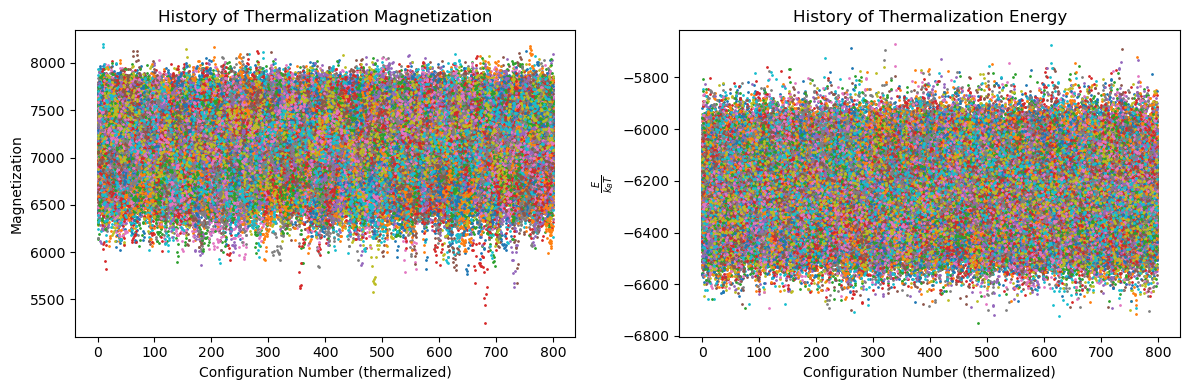

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Plot Magnetization
for i in range(magnetization_replicas_cropped.shape[0]):
    axes[0].scatter(range(config_number-Thermalization_start),magnetization_replicas_cropped[i,:], s = 1)
axes[0].set_xlabel('Configuration Number (thermalized)')
axes[0].set_ylabel('Magnetization')
axes[0].set_title('History of Thermalization Magnetization')

# Plot Energy
for i in range(energy_replicas_cropped.shape[0]):
    axes[1].scatter(range(config_number-Thermalization_start),energy_replicas_cropped[i,:], s = 1)
axes[1].set_xlabel('Configuration Number (thermalized)')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$')
axes[1].set_title('History of Thermalization Energy')

plt.tight_layout()
plt.show()

To calculate the expectation values $\langle\langle M\rangle\rangle$ and $\langle\langle \hat{H} \rangle\rangle$ we first calculate the mean for each replica and calculate the average of all the replica means. The statistical error is then calculated as the average of standard deviation of each replica mean from the expectaion value.

In [26]:
# expectation value of Magnetization
replica_magn_means = 0
replica_enrg_means = 0
for i in range(replica_count):
    replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
    replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


expc_magnetization = 1/replica_count*replica_magn_means
expc_energy = 1/replica_count*replica_enrg_means
magn_stdev = 0
enrg_stdev = 0
for i in range(replica_count):
    magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
    enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

The determined expectation values are in the $1\sigma$ range from provided reference values:

In [38]:
print(f"The expectation value of <M> is {expc_magnetization:.5e} ± {error_magnetization:.5e}")
print(f"The expectation value of is <H^> {expc_energy:.5e} ± {error_energy:.5e}")

The expectation value of <M> is 7.18404e+03 ± 2.21933e+00
The expectation value of is <H^> -6.23655e+03 ± 6.52624e-01


We can now plot the probability distribution of the magnetization and energy during each metropolis algorithm. For the histogram, we can determine expectation values of how often each magentization or energy value appears in the 1000 configurations the algorithm generates. We have chosen here 20 bins and can therefore define the expectaion value of how often a configuration observable falls in a specific bin. Analogously we can calculate the statistical error.

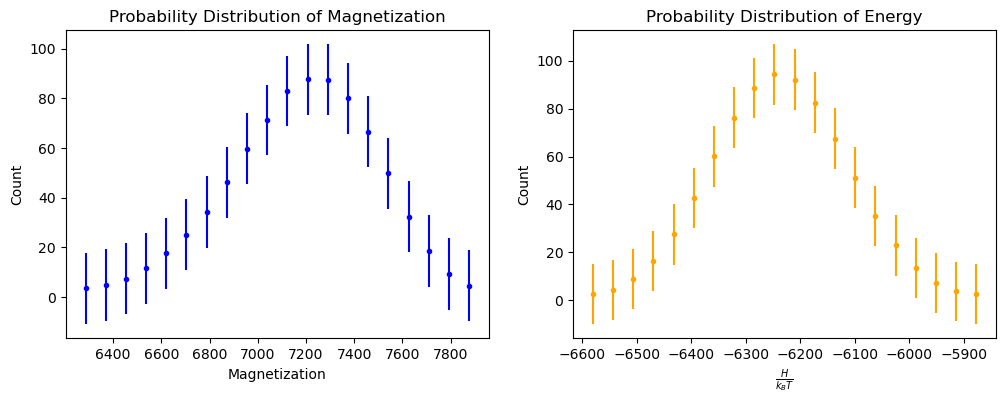

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bins = 20
magnetization_counts_array = np.zeros((replica_count,bins))
energy_counts_array = np.zeros((replica_count,bins))
magnetization_bins_array = np.zeros((replica_count,bins))
energy_bins_array = np.zeros((replica_count,bins))
for i in range(replica_count):
    counts,bin_edges = np.histogram(magnetization_replicas_cropped[i,:],bins)
    magnetization_counts_array[i,:] = counts
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    magnetization_bins_array[i,:] = bin_centres  

for i in range(replica_count):
    counts,bin_edges = np.histogram(energy_replicas_cropped[i,:],bins)
    energy_counts_array[i,:] = counts
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    energy_bins_array[i,:] = bin_centres 

magnetization_counts_means = np.zeros((bins,))
energy_counts_means = np.zeros((bins,))
magnetization_bins_means = np.zeros((bins,))
energy_bins_means = np.zeros((bins,))
for i in range(bins):
    magnetization_counts_means[i] =np.mean(magnetization_counts_array[:,i])    
    energy_counts_means[i]  = np.mean(energy_counts_array[:,i])
    magnetization_bins_means[i] =np.mean(magnetization_bins_array[:,i])    
    energy_bins_means[i]  = np.mean(energy_bins_array[:,i])


# expc_magnetization = 1/replica_count*magnetization_counts_means
# expc_energy = 1/replica_count*energy_counts__means


magn_counts_stdev = np.zeros((bins,))
enrg_counts_stdev = np.zeros((bins,))
magn_bins_stdev = np.zeros((bins,))
enrg_bins_stdev = np.zeros((bins,))
for i in range(bins):
    magn_counts_stdev[i] = ((np.mean(magnetization_replicas_cropped[:,i]) - magnetization_counts_means[i])**2/(replica_count*(replica_count-1)))**0.5
    enrg_counts_stdev[i] = ((np.mean(energy_replicas_cropped[:,i]) - energy_counts_means[i])**2 /(replica_count*(replica_count-1)))**0.5
    magn_bins_stdev[i] = ((np.mean(magnetization_replicas_cropped[:,i]) - magnetization_bins_means[i])**2/(replica_count*(replica_count-1)))**0.5
    enrg_bins_stdev[i] = ((np.mean(energy_replicas_cropped[:,i]) - energy_bins_means[i])**2 /(replica_count*(replica_count-1)))**0.5

# error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
# error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)





axes[0].errorbar(magnetization_bins_means, magnetization_counts_means,yerr= magn_counts_stdev,xerr = magn_bins_stdev,   fmt='.', color = 'blue')

axes[0].set_xlabel('Magnetization')
axes[0].set_ylabel('Count')
axes[0].set_title('Probability Distribution of Magnetization')

axes[1].errorbar(energy_bins_means, energy_counts_means,yerr= enrg_counts_stdev, xerr = enrg_bins_stdev,  fmt='.', color = 'orange')
axes[1].set_xlabel(r'$\frac{H}{k_B T}$')
axes[1].set_ylabel('Count')
axes[1].set_title('Probability Distribution of Energy')

plt.show()

## Statistical error behaviour

### Increasing number of configurations

We shall now prove numerically that an increase of configuration number for given replica count reduces the statistical error.

In [90]:
replica_count = 10
config_number_list = list(range(100,500, 10))
errors_array = np.zeros((2,len(config_number_list)))
for j,config_number in enumerate(config_number_list):
    magnetization_replicas = []
    energy_replicas = []
    for i in range (replica_count):
        print(f'{i}/{replica_count}', end='\r')
        magnetization_history, energy_history = metropolis_algorithm(20,2,0.43,0.01, i,config_number,"hot")
        magnetization_replicas.append(magnetization_history)
        energy_replicas.append(energy_history)


    Thermalization_start = 25
    magnetization_replicas_array = np.array(magnetization_replicas)
    energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
    magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]



    replica_magn_means = 0
    replica_enrg_means = 0
    for i in range(replica_count):
        replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
        replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


    expc_magnetization = 1/replica_count*replica_magn_means
    expc_energy = 1/replica_count*replica_enrg_means
    magn_stdev = 0
    enrg_stdev = 0
    for i in range(replica_count):
        magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
        enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

    error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
    error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

    errors_array[0,j] = error_magnetization
    errors_array[1,j] = error_energy


In [92]:
from scipy.optimize import curve_fit
def fit_function(x, a,b,c):
    return a/(x) +c

params, covariance = curve_fit(fit_function, config_number_list, errors_array[0,:], maxfev=10000)
a,b,c = params
y_fit_0 = fit_function(config_number_list, a,b,c)

params, covariance = curve_fit(fit_function, config_number_list, errors_array[1,:], maxfev=10000)
a,b,c = params
y_fit_1 = fit_function(config_number_list, a,b,c)

c:\Users\crpdn\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


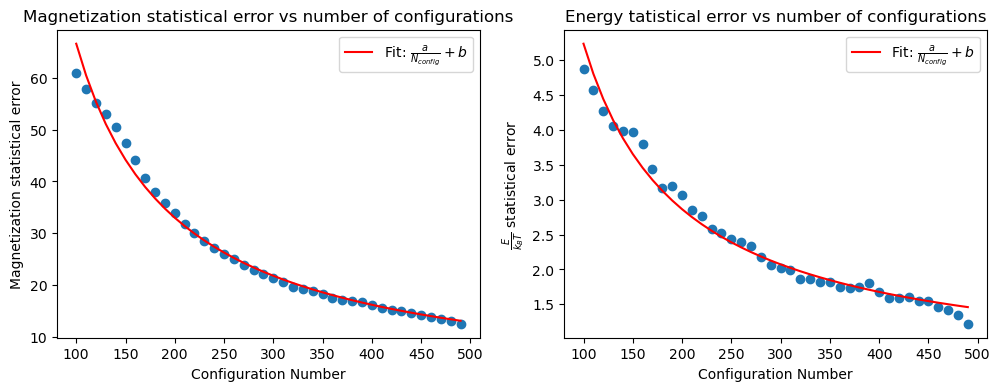

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(config_number_list, errors_array[0,:])
axes[0].plot(config_number_list, y_fit_0, color = 'red', label=r'Fit: $\frac{a}{N_{config}}+b$')
axes[1].scatter(config_number_list, errors_array[1,:])
axes[1].plot(config_number_list, y_fit_1, color = 'red', label=r'Fit: $\frac{a}{N_{config}}+b$')
axes[0].set_xlabel('Configuration Number')
axes[0].set_ylabel('Magnetization statistical error')
axes[0].set_title('Magnetization statistical error vs number of configurations')
axes[0].legend()

axes[1].set_xlabel('Configuration Number')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$ statistical error')
axes[1].set_title('Energy tatistical error vs number of configurations')
axes[1].legend()

We show that the statistial error $\sigma$ decreases with increasing number of configurations $N_{conf}$ following an inverse relationship $\sigma \propto \frac{1}{N_{conf}}$.

### Increasing number of replicas


We shall now prove numerically that an increase in the number of replicas for given configuration count reduces the statistical error.

In [98]:
config_number = 100
replica_count_list = list(range(40, 200, 10))
errors_array = np.zeros((2,len(replica_count_list)))
for j,replica_count in enumerate(replica_count_list):
    magnetization_replicas = []
    energy_replicas = []
    for i in range (replica_count):
        print(f'{i}/{replica_count}', end='\r')
        magnetization_history, energy_history = metropolis_algorithm(10,2,0.43,0.01, i,config_number,"hot")
        magnetization_replicas.append(magnetization_history)
        energy_replicas.append(energy_history)


    Thermalization_start = 25
    magnetization_replicas_array = np.array(magnetization_replicas)
    energy_replicas_cropped = np.array(energy_replicas)[:,Thermalization_start:]
    magnetization_replicas_cropped = magnetization_replicas_array[:,Thermalization_start:]



    replica_magn_means = 0
    replica_enrg_means = 0
    for i in range(replica_count):
        replica_magn_means += np.mean(magnetization_replicas_cropped[i,:])    
        replica_enrg_means += np.mean(energy_replicas_cropped[i,:])


    expc_magnetization = 1/replica_count*replica_magn_means
    expc_energy = 1/replica_count*replica_enrg_means
    magn_stdev = 0
    enrg_stdev = 0
    for i in range(replica_count):
        magn_stdev += (np.mean(magnetization_replicas_cropped[i,:]) - expc_magnetization)**2
        enrg_stdev += (np.mean(energy_replicas_cropped[i,:]) - expc_energy)**2 

    error_magnetization = (1/(replica_count*(replica_count-1))* magn_stdev)**(0.5)
    error_energy = (1/(replica_count*(replica_count-1))* enrg_stdev)**(0.5)

    errors_array[0,j] = error_magnetization
    errors_array[1,j] = error_energy

In [101]:
from scipy.optimize import curve_fit
def fit_function(x, a,b,c):
    return a/(x) +c

params, covariance = curve_fit(fit_function, replica_count_list, errors_array[0,:], maxfev=10000)
a,b,c = params
y_fit_0 = fit_function(replica_count_list, a,b,c)

params, covariance = curve_fit(fit_function, replica_count_list, errors_array[1,:], maxfev=10000)
a,b,c = params
y_fit_1 = fit_function(replica_count_list, a,b,c)

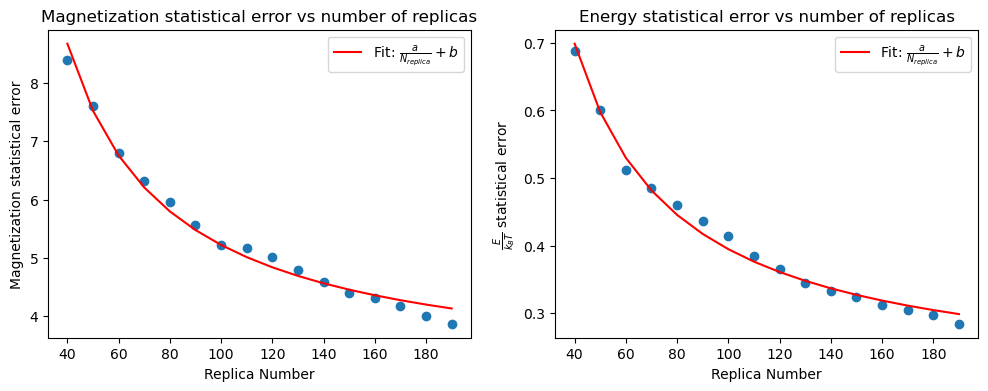

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(replica_count_list, errors_array[0,:])
axes[0].plot(replica_count_list, y_fit_0, color = 'red', label=r'Fit: $\frac{a}{N_{replica}}+b$')
axes[1].scatter(replica_count_list, errors_array[1,:])
axes[1].plot(replica_count_list, y_fit_1, color = 'red', label=r'Fit: $\frac{a}{N_{replica}}+b$')
axes[0].set_xlabel('Replica Number')
axes[0].set_ylabel('Magnetization statistical error')
axes[0].set_title('Magnetization statistical error vs number of replicas')
axes[0].legend()
axes[1].set_xlabel('Replica Number')
axes[1].set_ylabel(r'$\frac{E}{k_B T}$ statistical error')
axes[1].set_title('Energy statistical error vs number of replicas')
axes[1].legend()

We show that the statistial error $\sigma$ decreases with increasing number of replicas $N_{repica}$ following an inverse relationship $\sigma \propto \frac{1}{N_{replica}}$.

The statistical error of the expectation value is calculated by computing the mean over the number of configurations as well as calculating the average of the means over the replicas. For both calculations we devide by the number of configurations and number of replicas respectively. Increasing any or both of these numbers therefore results in a decrease of the statistical error according to the inverse relationship as shown through fitting of the above curves. 